[tuto dipy](https://dipy.org/documentation/1.4.1./examples_built/tracking_introduction_eudx/#example-tracking-introduction-eudx)

In [4]:
# Import des modules
import numpy as np
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.reconst.dti as dti
from dipy.data import get_fnames

# Select patch
minx = 1
maxx = 81
miny = 1
maxy = 106
minz = 28
maxz = 32

# Télécharge des données HARDI
hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
data, affine = load_nifti(hardi_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

# Force affine to something simple to make it easier to extract patches
affine = np.eye(4)

# Masque les données et estime les tenseurs
from dipy.segment.mask import median_otsu
data = data[:, :, minz:maxz, :]
maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                             numpass=1, autocrop=True, dilate=2)
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(maskdata)

# Génère métriques dérivées (FA etc)
from dipy.reconst.dti import fractional_anisotropy, color_fa
FA = fractional_anisotropy(tenfit.evals)
FA[np.isnan(FA)] = 0
FA = np.clip(FA, 0, 1)
RGB = color_fa(FA, tenfit.evecs)
MD1 = dti.mean_diffusivity(tenfit.evals)

# Figure
from dipy.data import get_sphere
sphere = get_sphere('repulsion724')
from dipy.viz import window, actor
scene = window.Scene()
evals = tenfit.evals[minx:maxx, miny:maxy, :]
evecs = tenfit.evecs[minx:maxx, miny:maxy, :]

# boost the colors
RGB *= 2
RGB[RGB>1] = 1
cfa = RGB[minx:maxx, miny:maxy, :]
scene.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere,
                              scale=0.3))
scene.set_camera(position=(14.87946710578175, 25.770232149765413, 173.54578028650144),
                 focal_point=(33.43851200470716, 40.67356830562871, 15.545914873824975),
                 view_up=(0.003256400517440014, 0.9955397521536979, 0.09428678453221151))
window.record(scene, n_frames=1, out_path='tensor-slice.png',
              size=(1000, 1000), reset_camera=False)
scene.set_camera(position=(6.398539759431944, 36.122368120824724, 21.074961978614017),
                 focal_point=(17.02336666201742, 55.39317316617157, 7.230217513090364),
                 view_up=(0.10205867972271891, 0.5426923506538308, 0.8337080055001721))
window.record(scene, n_frames=1, out_path='tensor-zoom.png',
              size=(600, 600), reset_camera=False)   

# Make figure 
from matplotlib import pyplot as plt
import imageio
fig1, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=200,
                        subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.3, wspace=0.05)
im = imageio.imread('tensor-slice.png')
ax.flat[0].imshow(im, interpolation='antialiased')
ax.flat[0].set_title('full slice')
im = imageio.imread('tensor-zoom.png')
ax.flat[1].imshow(im, interpolation='none')
ax.flat[1].set_title('zoom')

Text(0.5, 1.0, 'zoom')

Text(0.5, 1.0, 'masque de la matière blanche')

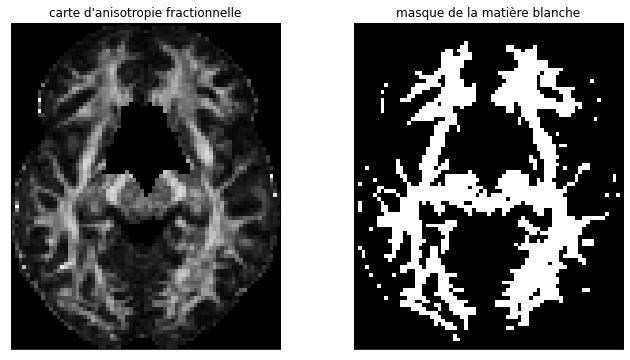

In [5]:
from matplotlib import pyplot as plt
MD = MD1
MD[mask==0] = 0
threshold_fa = 0.3
mask_wm = FA > threshold_fa


fig1, ax = plt.subplots(1, 2, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)
ax.flat[0].imshow(np.squeeze(FA[:, :, 0]).T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[0].set_title('carte d\'anisotropie fractionnelle')
ax.flat[1].imshow(np.squeeze(mask_wm[:, :, 0]).T, origin='lower',
                  cmap='gray')
ax.flat[1].set_title('masque de la matière blanche')


In [6]:
from dipy.tracking import utils

seeds = utils.seeds_from_mask(mask_wm[minx:maxx, miny:maxy, :], affine, density=[1, 1, 1])

from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

stopping_criterion = ThresholdStoppingCriterion(FA, 0.1)

from dipy.direction import peaks_from_model
csa_peaks = peaks_from_model(tenmodel, maskdata[minx:maxx, miny:maxy, :, :], sphere,
                             relative_peak_threshold=.8,
                             min_separation_angle=45,
                             mask=mask_wm[minx:maxx, miny:maxy, :])

from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines

# Initialization of LocalTracking. The computation happens in the next step.
streamlines_generator = LocalTracking(csa_peaks, stopping_criterion, seeds,
                                      affine=affine, step_size=0.2, max_cross=2)
# Generate streamlines object
streamlines = Streamlines(streamlines_generator)

In [7]:
from dipy.viz import colormap
color = colormap.line_colors(streamlines)
streamlines_actor = actor.line(streamlines,
                               colormap.line_colors(streamlines))

# Create the 3D display.
scene = window.Scene()
scene.add(streamlines_actor)
scene.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere,
                              scale=0.3))
scene.set_camera(position=(14.87946710578175, 25.770232149765413, 173.54578028650144),
                 focal_point=(33.43851200470716, 40.67356830562871, 15.545914873824975),
                 view_up=(0.003256400517440014, 0.9955397521536979, 0.09428678453221151))
window.record(scene, n_frames=1, out_path='fibers-slice.png',
              size=(1000, 1000), reset_camera=False)
scene.set_camera(position=(6.398539759431944, 36.122368120824724, 21.074961978614017),
                 focal_point=(17.02336666201742, 55.39317316617157, 7.230217513090364),
                 view_up=(0.10205867972271891, 0.5426923506538308, 0.8337080055001721))
window.record(scene, n_frames=1, out_path='fibers-zoom.png',
              size=(600, 600), reset_camera=False) 

# Make figure 
from matplotlib import pyplot as plt
import imageio
fig1, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=200,
                        subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.3, wspace=0.05)
im = imageio.imread('fibers-slice.png')
ax.flat[0].imshow(im, interpolation='antialiased')
ax.flat[0].set_title('full slice')
im = imageio.imread('fibers-zoom.png')
ax.flat[1].imshow(im, interpolation='none')
ax.flat[1].set_title('zoom')

Text(0.5, 1.0, 'zoom')

Text(0.5, 1.0, 'zoom')

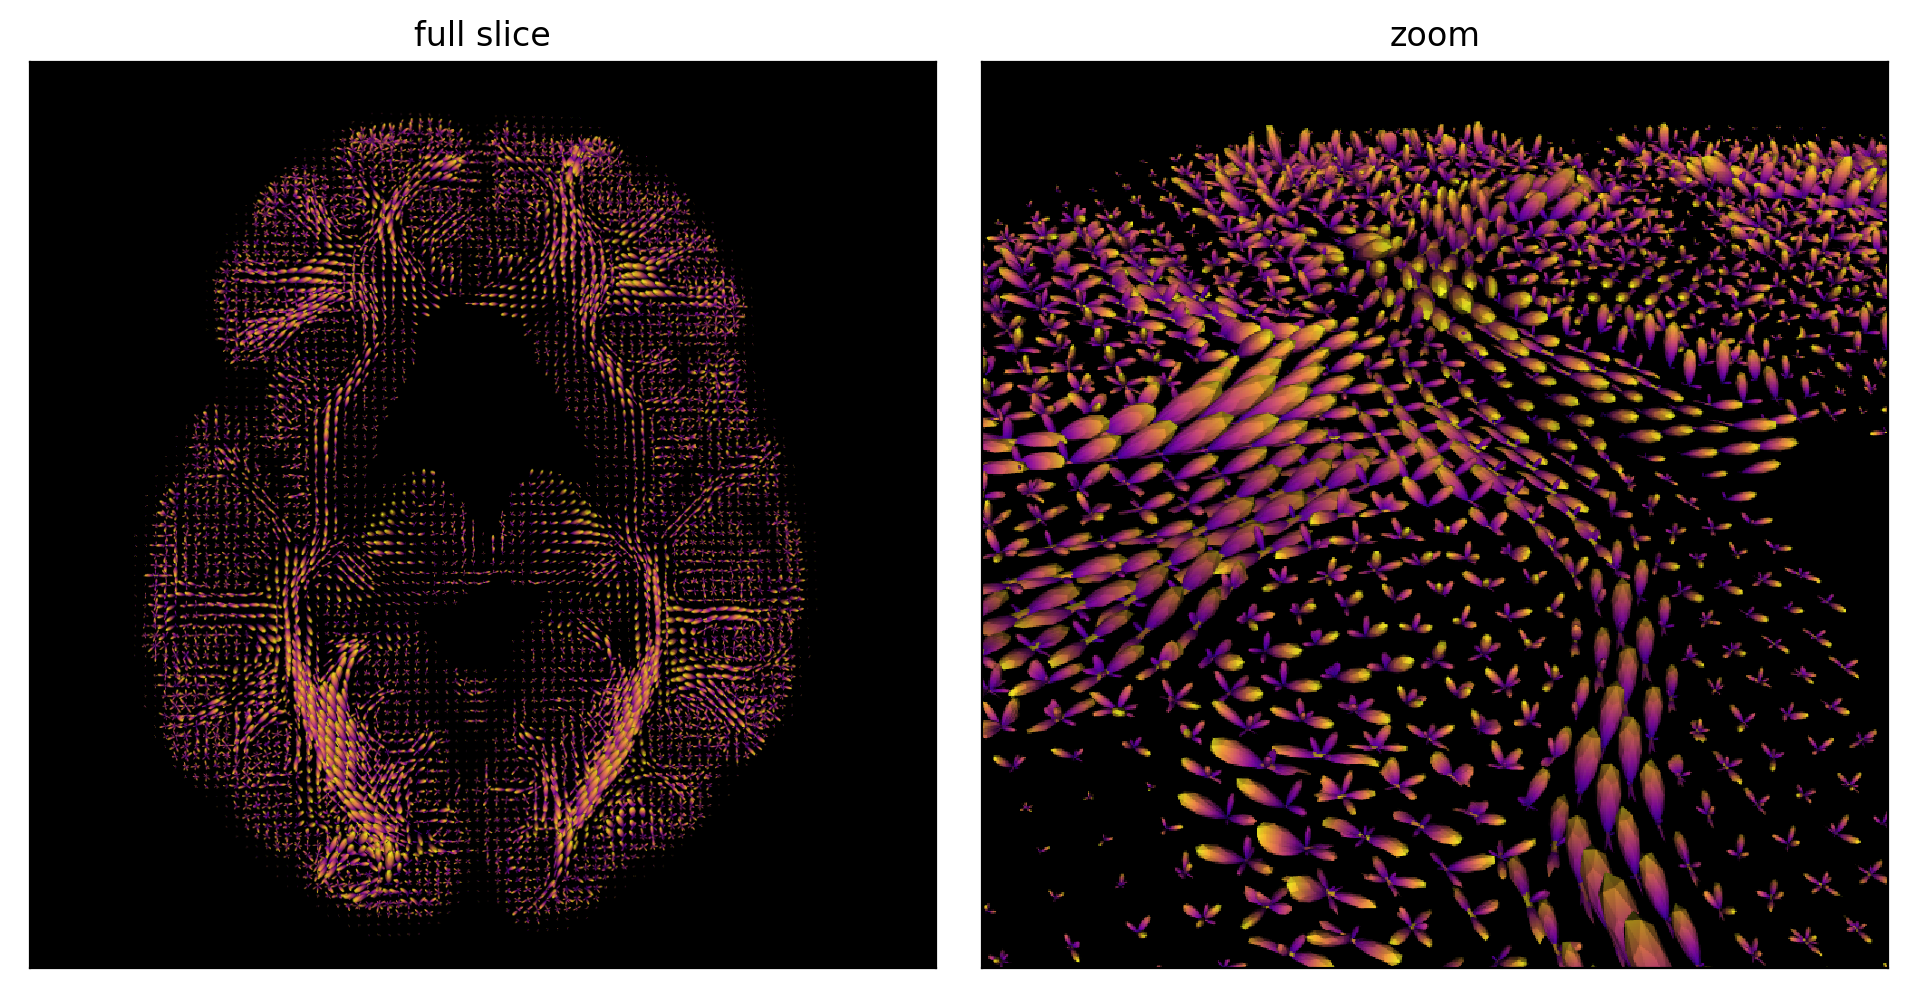

In [26]:
from dipy.reconst.csdeconv import auto_response_ssst
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel
from dipy.data import default_sphere
response, ratio = auto_response_ssst(gtab, maskdata, roi_radii=10, fa_thr=0.7)
csd_model = ConstrainedSphericalDeconvModel(gtab, response)
csd_fit = csd_model.fit(maskdata)
csd_odf = csd_fit.odf(default_sphere)
from dipy.data import default_sphere
fodf_spheres = actor.odf_slicer(csd_odf, sphere=default_sphere, scale=0.9,
                                norm=False, colormap='plasma')

# Create the 3D display.
scene = window.Scene()
scene.add(fodf_spheres)
scene.set_camera(position=(14.87946710578175, 25.770232149765413, 173.54578028650144),
                 focal_point=(33.43851200470716, 40.67356830562871, 15.545914873824975),
                 view_up=(0.003256400517440014, 0.9955397521536979, 0.09428678453221151))
window.record(scene, n_frames=1, out_path='fodf-slice.png',
              size=(1000, 1000), reset_camera=False)
scene.set_camera(position=(6.398539759431944, 36.122368120824724, 21.074961978614017),
                 focal_point=(17.02336666201742, 55.39317316617157, 7.230217513090364),
                 view_up=(0.10205867972271891, 0.5426923506538308, 0.8337080055001721))
window.record(scene, n_frames=1, out_path='fodf-zoom.png',
              size=(600, 600), reset_camera=False)   

# Make figure 
from matplotlib import pyplot as plt
import imageio
fig1, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=200,
                        subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.3, wspace=0.05)
im = imageio.imread('fodf-slice.png')
ax.flat[0].imshow(im, interpolation='antialiased')
ax.flat[0].set_title('full slice')
im = imageio.imread('fodf-zoom.png')
ax.flat[1].imshow(im, interpolation='none')
ax.flat[1].set_title('zoom')

Text(0.5, 1.0, 'zoom')

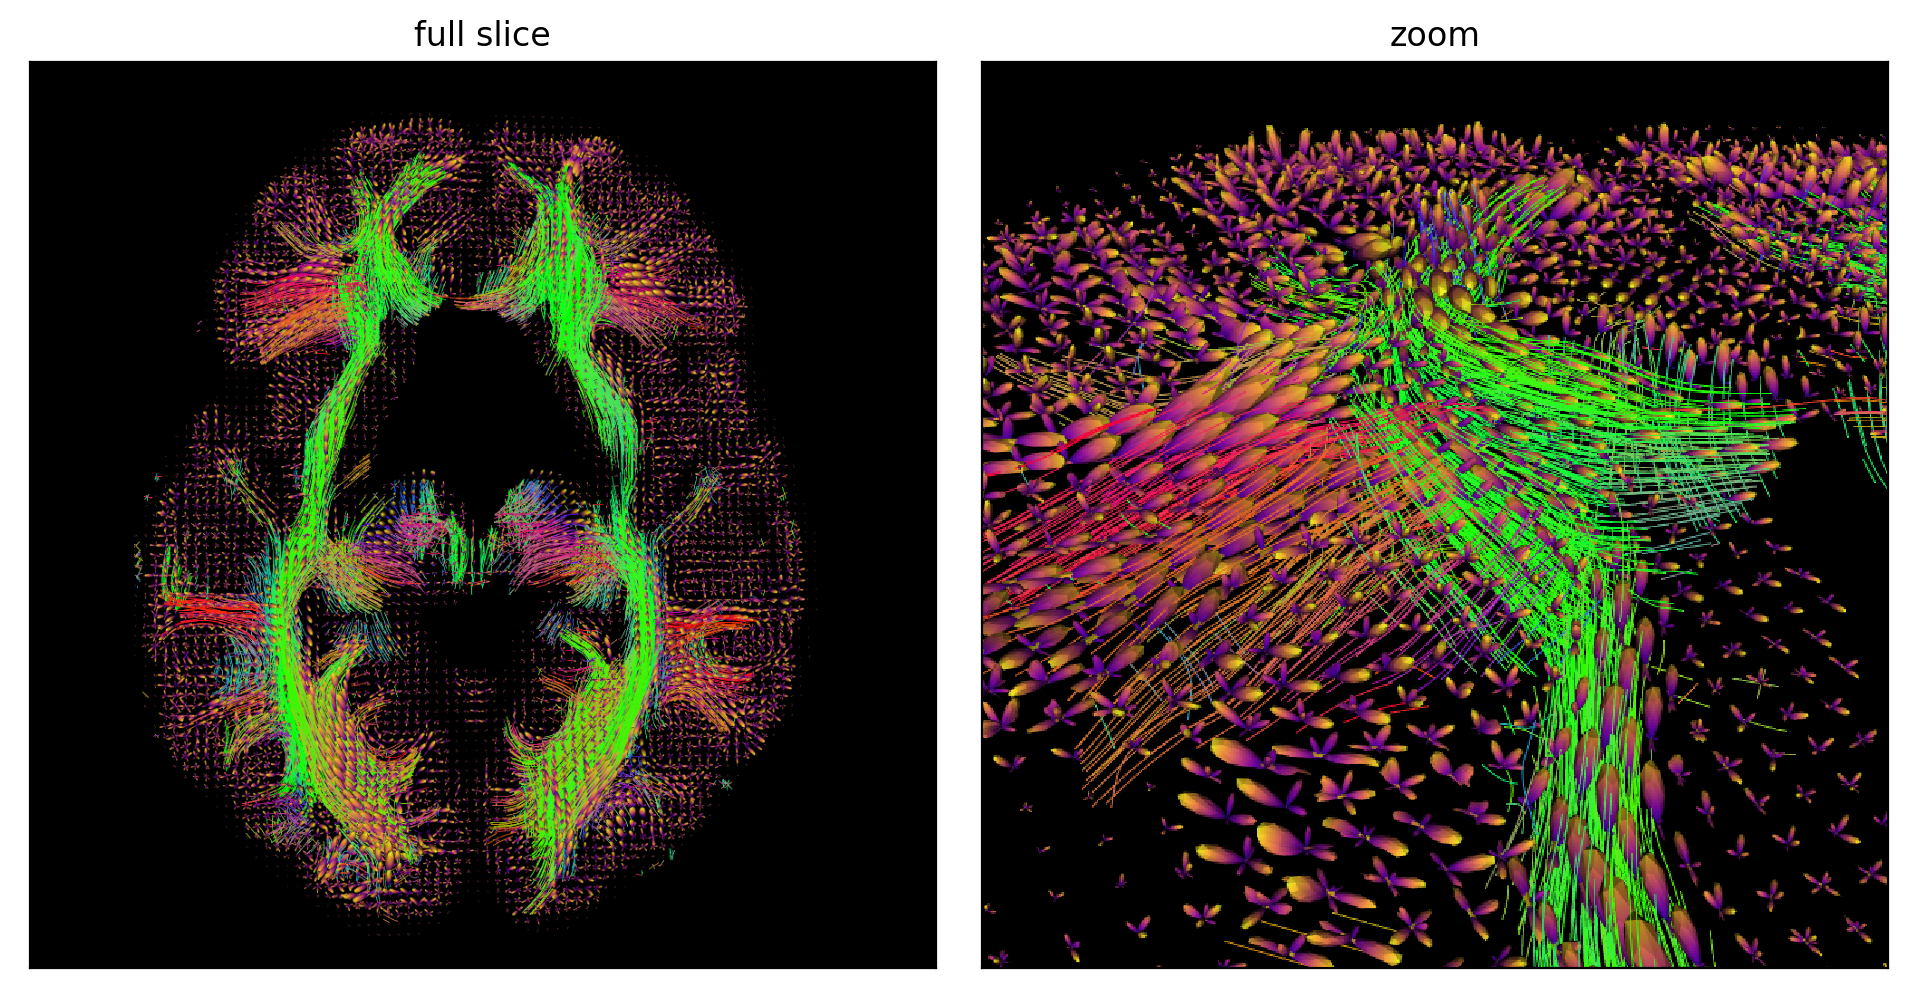

In [30]:
csa_peaks = peaks_from_model(csd_model, maskdata[minx:maxx, miny:maxy, :, :], default_sphere,
                             relative_peak_threshold=.5,
                             min_separation_angle=15,
                             mask=mask_wm[minx:maxx, miny:maxy, :])

# Initialization of LocalTracking. The computation happens in the next step.
streamlines_generator = LocalTracking(csa_peaks, stopping_criterion, seeds,
                                      affine=affine, step_size=0.2, max_cross=5)
# Generate streamlines object
streamlines = Streamlines(streamlines_generator)

from dipy.viz import colormap
color = colormap.line_colors(streamlines)
streamlines_actor = actor.line(streamlines,
                               colormap.line_colors(streamlines))

# Create the 3D display.
scene = window.Scene()
scene.add(streamlines_actor)
scene.add(fodf_spheres)
scene.set_camera(position=(14.87946710578175, 25.770232149765413, 173.54578028650144),
                 focal_point=(33.43851200470716, 40.67356830562871, 15.545914873824975),
                 view_up=(0.003256400517440014, 0.9955397521536979, 0.09428678453221151))
window.record(scene, n_frames=1, out_path='fibers-slice.png',
              size=(1000, 1000), reset_camera=False)
scene.set_camera(position=(6.398539759431944, 36.122368120824724, 21.074961978614017),
                 focal_point=(17.02336666201742, 55.39317316617157, 7.230217513090364),
                 view_up=(0.10205867972271891, 0.5426923506538308, 0.8337080055001721))
window.record(scene, n_frames=1, out_path='fibers-zoom.png',
              size=(600, 600), reset_camera=False) 

# Make figure 
from matplotlib import pyplot as plt
import imageio
fig1, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=200,
                        subplot_kw={'xticks': [], 'yticks': []})
fig1.subplots_adjust(hspace=0.3, wspace=0.05)
im = imageio.imread('fibers-slice.png')
ax.flat[0].imshow(im, interpolation='antialiased')
ax.flat[0].set_title('full slice')
im = imageio.imread('fibers-zoom.png')
ax.flat[1].imshow(im, interpolation='none')
ax.flat[1].set_title('zoom')